In [ ]:
# Importing packages
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
from datetime import date 
import math 
import statistics

from sklearn.metrics import mean_squared_log_error, mean_squared_error 
from sklearn.model_selection import TimeSeriesSplit 
from statistics import mean

In [62]:
# Helper Classes and Functions

# We build the decision tree using RSS criteria
# Function to determine the best split at each bud
def RSS_criteria(child_L, child_R, parent, median_flag=False):
    if(median_flag): #Uses median instead of mean to calculate RSS to make it more robust to outliers.
      rss_parent = sum((parent - statistics.median(parent))**2)
      rss_child_L = sum((child_L - statistics.median(child_L))**2) 
      rss_child_R = sum((child_R - statistics.median(child_R))**2)
    else: #Uses mean to calculate RSS instead of median if data set has many 0's as in the case of predicting no. of deaths.
      rss_parent = sum((parent - np.mean(parent))**2)
      rss_child_L = sum((child_L - np.mean(child_L))**2) 
      rss_child_R = sum((child_R - np.mean(child_R))**2)
    return rss_parent - (rss_child_L + rss_child_R) # Check how much a split reduces the parent node's RSS

# Returns the median of values based on cumulative sum of weights.
def weighted_median(values, weights):
    sorted_indices = values.argsort()
    values = values[sorted_indices]
    weights = weights[sorted_indices]
    weights_cumulative_sum = weights.cumsum()
    median_weight = np.argmax(weights_cumulative_sum >= sum(weights)/2)
    return values[median_weight]

# Function that stop the node from splitting if the training observations are all the same
def equal_rows(X):
    return (X == X[0]).all()

# Function that provides a list of unique values in x; used for in spltting
def sorted_x_y(x, y):
    uni_xs = np.unique(x)
    y_mean_for_x = np.array([y[x == uni_x].mean() for uni_x in uni_xs])
    ordered_xs = uni_xs[np.argsort(y_mean_for_x)]
    return ordered_xs

# Class for representing the decision tree nodes, its attributes and whether the node is a leaf node or not.
class DecisionTreeNode:
    
    def __init__(self, Xsub, ysub, ID, depth = 0, parent_ID = None, leaf = True):
        self.ID = ID
        self.Xsub = Xsub
        self.ysub = ysub
        self.size = len(ysub)
        self.depth = depth
        self.parent_ID = parent_ID
        self.leaf = leaf

# Class that identifies the best split for the bud. 
class NodeSplitter:
    
    # Constructor that sets itself up with the default case of no splitting (leaf node)
    def __init__(self):
        self.rss_reduction = 0
        self.no_split = True # Default split status
    
    # Function to capture the split's reduction in RSS, a variable d that makes the split, the data type, the threshold (to manage overfitting),the L values ( a set of values), and split status
    def _replace_split(self, rss_reduction, d, dtype = 'quant', t = None, L_values = None):
        self.rss_reduction = rss_reduction
        self.d = d # d is the chosen predictor that splits the node
        self.dtype = dtype
        self.t = t # t is the threshold value       
        self.L_values = L_values     
        self.no_split = False # Change split status

In [63]:
# Class used to build the model and prediction in the individual decision tree.
class DecisionTreeRegressor:

    # Fit the data. Uses the provided training data, parameter C is null in the single decision tree case
    def fit(self, X, y, max_depth = 100, min_size = 2, C = None):
        
        # Adds the data
        self.X = X
        self.y = y
        self.N, self.D = self.X.shape
        dtypes = [np.array(list(self.X[:,d])).dtype for d in range(self.D)]
        self.dtypes = ['quant' if (dtype == float or dtype == int) else 'cat' for dtype in dtypes] # Differentiates between categorical and numerical variable types
        
        # Adds regularization parameters
        self.max_depth = max_depth
        self.min_size = min_size
        self.C = C
        
        # Initializes the nodes
        self.nodes_dict = {}
        self.current_ID = 0 # Builds node IDs used for building the tree
        root_node = DecisionTreeNode(Xsub = X, ysub = y, ID = self.current_ID, parent_ID = None)
        self.nodes_dict[self.current_ID] = root_node
        self.current_ID += 1
        
        # Builds the tree using the _build function below
        self._build()
        
    # Build function for creating decision trees
    def _build(self):
        
        eligible_buds = self.nodes_dict 
        for layer in range(self.max_depth):
            
            # Finds the eligible nodes instantiated above for layer iteration
            eligible_buds = {ID:node for (ID, node) in self.nodes_dict.items() if 
                                (node.leaf == True) &
                                (node.size >= self.min_size) & 
                                (~equal_rows(node.Xsub)) &
                                (len(np.unique(node.ysub)) > 1)}
            if len(eligible_buds) == 0:
                break
                
            # Performs a split each eligible parent
            for ID, bud in eligible_buds.items():
                                
                # Finds the split
                self._find_split(bud)
                
                # Makes the split
                if not self.splitter.no_split: # provides the possibility of no split
                    self._make_split()
        
    
    # Function for finding the split reduces the bud's RSS
    def _find_split(self, bud):
        
        # Creates the splitter class
        splitter = NodeSplitter()
        splitter.bud_ID = bud.ID
        
        # Based on provided parameter c, this gathers eligible predictors for Random Forests
        if self.C is None:
            eligible_predictors = np.arange(self.D)
        else:
            eligible_predictors = np.random.choice(np.arange(self.D), self.C, replace = False)
        
        # For each eligible predictor
        for d in sorted(eligible_predictors):
            Xsub_d = bud.Xsub[:,d]
            dtype = self.dtypes[d]
            if len(np.unique(Xsub_d)) == 1:
                continue

            # For each threshold value
            if dtype == 'quant': # For quantitative variables
                for t in np.unique(Xsub_d)[:-1]:
                    ysub_L = bud.ysub[Xsub_d <= t]
                    ysub_R = bud.ysub[Xsub_d > t]
                    rss_reduction = RSS_criteria(ysub_L, ysub_R, bud.ysub)
                    if rss_reduction > splitter.rss_reduction:
                        splitter._replace_split(rss_reduction, d, dtype = 'quant', t = t)
            else:
                ordered_x = sorted_x_y(Xsub_d, bud.ysub) # For categorical variables
                for i in range(len(ordered_x) - 1):
                    L_values = ordered_x[:i+1]
                    ysub_L = bud.ysub[np.isin(Xsub_d, L_values)]
                    ysub_R = bud.ysub[~np.isin(Xsub_d, L_values)]
                    rss_reduction = RSS_criteria(ysub_L, ysub_R, bud.ysub)
                    if rss_reduction > splitter.rss_reduction: 
                        splitter._replace_split(rss_reduction, d, dtype = 'cat', L_values = L_values)
        
        # Saves the splitter
        self.splitter = splitter
        
    # Defines the function for making the split. It iterates through the layers of the tree, splits at the eligible nodes, and then repeats.
    def _make_split(self):
        # Updates the parent node
        parent_node = self.nodes_dict[self.splitter.bud_ID]
        parent_node.leaf = False
        parent_node.child_L = self.current_ID
        parent_node.child_R = self.current_ID + 1
        parent_node.d = self.splitter.d
        parent_node.dtype = self.splitter.dtype
        parent_node.t = self.splitter.t        
        parent_node.L_values = self.splitter.L_values
        
        # Get X and y data for children
        if parent_node.dtype == 'quant':
            L_condition = parent_node.Xsub[:,parent_node.d] <= parent_node.t
     
        else:
            L_condition = np.isin(parent_node.Xsub[:,parent_node.d], parent_node.L_values)
        Xchild_L = parent_node.Xsub[L_condition]
        ychild_L = parent_node.ysub[L_condition]
        Xchild_R = parent_node.Xsub[~L_condition]
        ychild_R = parent_node.ysub[~L_condition]

        
        # Creates the child nodes
        child_node_L = DecisionTreeNode(Xchild_L, ychild_L, depth = parent_node.depth + 1,
                            ID = self.current_ID, parent_ID = parent_node.ID)
        child_node_R = DecisionTreeNode(Xchild_R, ychild_R, depth = parent_node.depth + 1,
                            ID = self.current_ID+1, parent_ID = parent_node.ID)
        self.nodes_dict[self.current_ID] = child_node_L
        self.nodes_dict[self.current_ID + 1] = child_node_R
        self.current_ID += 2
        
    # Prediction portion
    
    # Defines the function _get_leaf_means that calculates the average of the y variable among training observations in each leaf
    def _get_leaf_means(self):
        self.leaf_means = {}
        for node_ID, node in self.nodes_dict.items():
            if node.leaf:
                self.leaf_means[node_ID] = node.ysub.mean()

                
    # Defines the predict function for DecisionTreeRegressor class that runs the test observation through the created tree and returns the mean of the y variable in the leaf
    def predict(self, X_test):
        
        # Calculates the leaf means
        self._get_leaf_means()
     
        yhat = []
        for x in X_test:
            node = self.nodes_dict[0] 
            while not node.leaf:
                if node.dtype == 'quant':
                    if x[node.d] <= node.t:
                        node = self.nodes_dict[node.child_L]
                    else:
                        node = self.nodes_dict[node.child_R]
                else:
                    if x[node.d] in node.L_values:
                        node = self.nodes_dict[node.child_L]
                    else:
                        node = self.nodes_dict[node.child_R]
            yhat.append(self.leaf_means[node.ID])
        return np.array(yhat)

In [64]:
class AdaBoostR2:
    
    def fit(self, X_train, y_train, T = 100, stub_depth = 1, random_state = None):
        
        self.y_train = y_train
        self.X_train = X_train
        self.T = T
        self.stub_depth = stub_depth
        self.N, self.D = X_train.shape
        self.weights = np.repeat(1/self.N, self.N)
        np.random.seed(random_state)
        
        self.trees = []    
        self.fitted_values = np.empty((self.N, self.T))
        self.betas = []
        for t in range(self.T):
            
            ## Draw sample, fit tree, get predictions
            bootstrap_indices = np.random.choice(np.arange(self.N), size = self.N, replace = True, p = self.weights)
            bootstrap_X = self.X_train[bootstrap_indices]
            bootstrap_y = self.y_train[bootstrap_indices]
            tree = DecisionTreeRegressor()
            tree.fit(bootstrap_X, bootstrap_y, max_depth = stub_depth)
            self.trees.append(tree)
            yhat = tree.predict(X_train)
            self.fitted_values[:,t] = yhat
            
            ## Calculate observation errors
            abs_errors_t = np.abs(self.y_train - yhat)
            D_t = np.max(abs_errors_t)
            L_ts = abs_errors_t/D_t
            
            ## Calculate model error (and possibly break)
            Lbar_t = np.sum(self.weights*L_ts)
            if Lbar_t >= 0.5:
                self.T = t - 1
                self.fitted_values = self.fitted_values[:,:t-1]
                self.trees = self.trees[:t-1]
                break
            
            ## Calculate and record beta 
            beta_t = Lbar_t/(1 - Lbar_t)
            self.betas.append(beta_t)
            
            ## Reweight
            Z_t = np.sum(self.weights*beta_t**(1-L_ts))
            self.weights *= beta_t**(1-L_ts)/Z_t
            
        ## Get median 
        self.model_weights = np.log(1/np.array(self.betas))
        self.y_train_hat = np.array([weighted_median(self.fitted_values[n], self.model_weights) for n in range(self.N)])
        
    def predict(self, X_test):
        N_test = len(X_test)
        fitted_values = np.empty((N_test, self.T))
        for t, tree in enumerate(self.trees):
            fitted_values[:,t] = tree.predict(X_test)
        return np.array([weighted_median(fitted_values[n], self.model_weights) for n in range(N_test)]) 

In [81]:
# Loads the data, make sure the csv file is in the same working directory
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [82]:
# Drops the first uknown column in the data
train = train.drop('Unnamed: 0', axis=1)
test = test.drop('Unnamed: 0', axis=1)

In [83]:
# Defines a class, date_to_int, that transforms the Date feature into an integer that represents the days past the initial date found in the data, Jan 21, 2021.
# Transformation of the data for time series analysis
def date_to_int(d):
    initial_date = date(2020, 1, 21)
    curr_date = [int(x) for x in d.split('-')]
    final_date = date(curr_date[0], curr_date[1], curr_date[2])
    delta = final_date - initial_date
    return delta.days

In [84]:
# Transforms the Country feature, a categorical feature, using one-hot encoding into an integer in a vector space representing that respective country
one_hot_train = pd.get_dummies(train['Country'])
train = train.join(one_hot_train)
# Applies the date_to_int function
train['Day'] = train['Date'].apply(lambda x: date_to_int(x))

In [80]:
# Done similarly with test data
one_hot_test = pd.get_dummies(test['Country'])
test = test.join(one_hot_train)
test['Day'] = test['Date'].apply(lambda x: date_to_int(x))

In [85]:
# Applies a log transform on the dependent variables 
train['log_Confirmed'] = train['Confirmed'].apply(lambda x: round(math.log(x+1),3))
train['log_Deaths'] = train['Deaths'].apply(lambda x: round(math.log(x+1),3))
train['log_Recovered'] = train['Recovered'].apply(lambda x: round(math.log(x+1),3))
train['log_Active'] = train['Active'].apply(lambda x: round(math.log(x+1),3))

In [86]:
# Done similarly with test data
test['log_Confirmed'] = test['Confirmed'].apply(lambda x: round(math.log(x+1),3))
test['log_Deaths'] = test['Deaths'].apply(lambda x: round(math.log(x+1),3))
test['log_Recovered'] = test['Recovered'].apply(lambda x: round(math.log(x+1),3))
test['log_Active'] = test['Active'].apply(lambda x: round(math.log(x+1),3))

In [87]:
# Drops the first seven columns in the data set that contained the untransformed features
train.drop(train.iloc[:, 0:6], inplace = True, axis = 1)
test.drop(test.iloc[:, 0:6], inplace = True, axis = 1)

In [88]:
# Grabbing x/y train test sets for 'Confirmed' cases
confirmed_train_x = train.drop(train.columns[[-1,-2,-3,-4]], axis = 1)
confirmed_train_y = train['log_Confirmed']

confirmed_test_x = test.drop(test.columns[[-1,-2,-3,-4]], axis = 1)
confirmed_test_y = test['log_Confirmed']

# Performing 5-fold cross validation on rolling basis for 'Confirmed' RF model
all_train = confirmed_train_x.append(confirmed_test_x).to_numpy()
all_values = confirmed_train_y.append(confirmed_test_y).to_numpy()

tscv = TimeSeriesSplit(n_splits=5)
rmse_scores = []
rmsle_scores = []

for train_index, test_index in tscv.split(all_train):
    X_train, X_test = all_train[train_index], all_train[test_index]
    y_train, y_test = all_values[train_index], all_values[test_index]
    
    booster = AdaBoostR2()
    booster.fit(X_train, y_train, T = 51, stub_depth = 4, random_state = 117)
    predict = booster.predict(X_test)
    rmse_scores.append(round(mean_squared_error(y_test, predict),3))
    rmsle_scores.append(round(mean_squared_log_error(y_test, predict),3))

print('Now predicting Confirmed Cases...')
print('Cross validated root mean squared errors are:', rmse_scores)
print('Average RMSE using AdaBoostR2 to predict Confirmed cases is:', mean(rmse_scores))
print()
print('Cross validated root mean squared log errors are:', rmsle_scores)
print('Average RMSLE using AdaBoostR2 to predict Confirmed cases is:', mean(rmsle_scores))

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Now predicting Confirmed Cases...
Cross validated root mean squared errors are: [0.946, 2.304, 58.354, 8.957, 10.438]
Average RMSE using AdaBoostR2 to predict Confirmed cases is: 16.1998

Cross validated root mean squared log errors are: [0.373, 0.549, 2.067, 0.347, 0.26]
Average RMSLE using AdaBoostR2 to predict Confirmed cases is: 0.7192000000000001


Text(0, 0.5, '$\\hat{y}$')

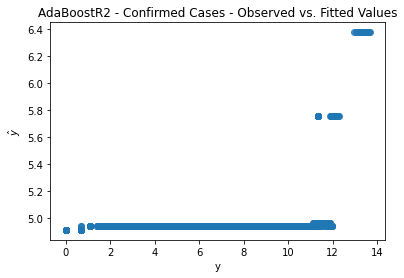

In [ ]:
# Plots the observed values, y, against the fittted values, y hat
df_pred = pd.DataFrame(list(y_test), columns = ['y_test'])
df_pred['predict'] = list(predict)

plt.scatter(df_pred['y_test'], df_pred['predict'], alpha = 0.8)
plt.title('AdaBoostR2 - Confirmed Cases - Observed vs. Fitted Values')
plt.xlabel('y')
plt.ylabel('$\hat{y}$')

In [ ]:
df_pred.corr()

,y_test,predict
y_test,1.000000,0.338665
predict,0.338665,1.000000


In [51]:
# Grabbing x/y train test sets for 'Deaths' cases
deaths_train_x = train.drop(train.columns[[-1,-2,-3,-4]], axis = 1)
deaths_train_y = train['log_Deaths']

deaths_test_x = test.drop(test.columns[[-1,-2,-3,-4]], axis = 1)
deaths_test_y = test['log_Deaths']

# Performing 5-fold cross validation on rolling basis for 'Deaths' RF model
all_train = deaths_train_x.append(deaths_test_x).to_numpy()
all_values = deaths_train_y.append(deaths_test_y).to_numpy()

tscv = TimeSeriesSplit(n_splits=5)
rmse_scores = []
rmsle_scores = []

for train_index, test_index in tscv.split(all_train):
    X_train, X_test = all_train[train_index], all_train[test_index]
    y_train, y_test = all_values[train_index], all_values[test_index]
    
    booster = AdaBoostR2()
    booster.fit(X_train, y_train, T = 60, stub_depth = 5, random_state = 117)
    predict = booster.predict(X_test)
    rmse_scores.append(round(mean_squared_error(y_test, predict),3))
    rmsle_scores.append(round(mean_squared_log_error(y_test, predict),3))

print('Now predicting Deaths Cases...')
print('Cross validated root mean squared errors are:', rmse_scores)
print('Average RMSE using AdaBoostR2 to predict Deaths cases is:', mean(rmse_scores))
print()
print('Cross validated root mean squared log errors are:', rmsle_scores)
print('Average RMSLE using AdaBoostR2 to predict Deaths cases is:', mean(rmsle_scores))

Now predicting Deaths Cases...
Cross validated root mean squared errors are: [0.011, 0.217, 1.203, 3.374, 5.093]
Average RMSE using AdaBoostR2 to predict Deaths cases is: 1.9796

Cross validated root mean squared log errors are: [0.004, 0.071, 0.326, 0.565, 0.558]
Average RMSLE using AdaBoostR2 to predict Deaths cases is: 0.3048


Text(0, 0.5, '$\\hat{y}$')

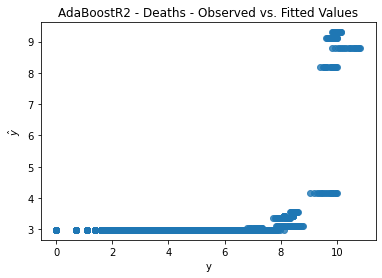

In [52]:
# Plots the observed values, y, against the fittted values, y hat
df_pred = pd.DataFrame(list(y_test), columns = ['y_test'])
df_pred['predict'] = list(predict)

plt.scatter(df_pred['y_test'], df_pred['predict'], alpha = 0.8)
plt.title('AdaBoostR2 - Deaths - Observed vs. Fitted Values')
plt.xlabel('y')
plt.ylabel('$\hat{y}$')

In [53]:
df_pred.corr()

,y_test,predict
y_test,1.000000,0.464702
predict,0.464702,1.000000


In [54]:
# Grabbing x/y train test sets for 'Recovered' cases
recovered_train_x = train.drop(train.columns[[-1,-2,-3,-4]], axis = 1)
recovered_train_y = train['log_Recovered']

recovered_test_x = test.drop(test.columns[[-1,-2,-3,-4]], axis = 1)
recovered_test_y = test['log_Recovered']

# Performing 5-fold cross validation on rolling basis for 'Deaths' RF model
all_train = recovered_train_x.append(recovered_test_x).to_numpy()
all_values = recovered_train_y.append(recovered_test_y).to_numpy()

tscv = TimeSeriesSplit(n_splits=5)
rmse_scores = []
rmsle_scores = []

for train_index, test_index in tscv.split(all_train):
    X_train, X_test = all_train[train_index], all_train[test_index]
    y_train, y_test = all_values[train_index], all_values[test_index]
    
    booster = AdaBoostR2()
    booster.fit(X_train, y_train, T = 50, stub_depth = 4, random_state = 123)
    predict = booster.predict(X_test)
    rmse_scores.append(round(mean_squared_error(y_test, predict),3))
    rmsle_scores.append(round(mean_squared_log_error(y_test, predict),3))

print('Now predicting Recovered Cases...')
print('Cross validated root mean squared errors are:', rmse_scores)
print('Average RMSE using AdaBoostR2 to predict Recovered cases is:', mean(rmse_scores))
print()
print('Cross validated root mean squared log errors are:', rmsle_scores)
print('Average RMSLE using AdaBoostR2 to predict Recovered cases is:', mean(rmsle_scores))

Now predicting Recovered Cases...
Cross validated root mean squared errors are: [0.195, 1.185, 2.205, 4.963, 7.775]
Average RMSE using AdaBoostR2 to predict Recovered cases is: 3.2646

Cross validated root mean squared log errors are: [0.055, 0.428, 0.595, 0.627, 0.499]
Average RMSLE using AdaBoostR2 to predict Recovered cases is: 0.44079999999999997


Text(0, 0.5, '$\\hat{y}$')

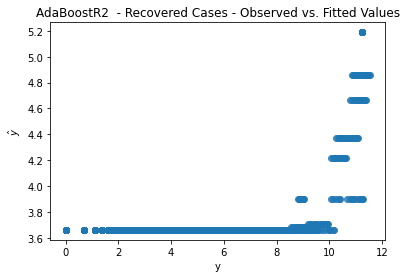

In [55]:
# Plots the observed values, y, against the fittted values, y hat
df_pred = pd.DataFrame(list(y_test), columns = ['y_test'])
df_pred['predict'] = list(predict)

plt.scatter(df_pred['y_test'], df_pred['predict'], alpha = 0.8)
plt.title('AdaBoostR2  - Recovered Cases - Observed vs. Fitted Values')
plt.xlabel('y')
plt.ylabel('$\hat{y}$')

In [56]:
df_pred.corr()

,y_test,predict
y_test,1.000000,0.442412
predict,0.442412,1.000000


In [57]:
# Grabbing x/y train test sets for 'Active' cases
active_train_x = train.drop(train.columns[[-1,-2,-3,-4]], axis = 1)
active_train_y = train['log_Active']

active_test_x = test.drop(test.columns[[-1,-2,-3,-4]], axis = 1)
active_test_y = test['log_Active']

# Performing 5-fold cross validation on rolling basis for 'Active' RF model
all_train = recovered_train_x.append(active_test_x).to_numpy()
all_values = recovered_train_y.append(active_test_y).to_numpy()

tscv = TimeSeriesSplit(n_splits=5)
rmse_scores = []
rmsle_scores = []

for train_index, test_index in tscv.split(all_train):
    X_train, X_test = all_train[train_index], all_train[test_index]
    y_train, y_test = all_values[train_index], all_values[test_index]
    
    booster = AdaBoostR2()
    booster.fit(X_train, y_train, T = 50, stub_depth = 4, random_state = 123)
    predict = booster.predict(X_test)
    rmse_scores.append(round(mean_squared_error(y_test, predict),3))
    rmsle_scores.append(round(mean_squared_log_error(y_test, predict),3))

print('Now predicting Active Cases...')
print('Cross validated root mean squared errors are:', rmse_scores)
print('Average RMSE using AdaBoostR2 to predict Active cases is:', mean(rmse_scores))
print()
print('Cross validated root mean squared log errors are:', rmsle_scores)
print('Average RMSLE using AdaBoostR2 to predict Active cases is:', mean(rmsle_scores))

Now predicting Active Cases...
Cross validated root mean squared errors are: [0.195, 1.185, 6.791, 8.375, 8.299]
Average RMSE using AdaBoostR2 to predict Active cases is: 4.969

Cross validated root mean squared log errors are: [0.055, 0.428, 0.612, 0.347, 0.27]
Average RMSLE using AdaBoostR2 to predict Active cases is: 0.3424


Text(0, 0.5, '$\\hat{y}$')

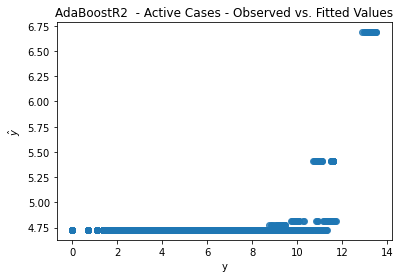

In [58]:
# Plots the observed values, y, against the fittted values, y hat
df_pred = pd.DataFrame(list(y_test), columns = ['y_test'])
df_pred['predict'] = list(predict)

plt.scatter(df_pred['y_test'], df_pred['predict'], alpha = 0.8)
plt.title('AdaBoostR2  - Active Cases - Observed vs. Fitted Values')
plt.xlabel('y')
plt.ylabel('$\hat{y}$')

In [59]:
df_pred.corr()

,y_test,predict
y_test,1.000000,0.297784
predict,0.297784,1.000000
